In [66]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from xfoil import XFoil
from xfoil.model import Airfoil

from lib.utils import load_pkl, save_pkl
from lib.preprocess_modules import *
from lib.predict_modules import *
from config import *

from nets.nn import *

In [2]:
model = light_param_net(3072)
model.load_weights(str(Path('./weights', '2020-12-25 10-16.h5')))

Light parametrization net output shape: (None, 512, 512, 1)


In [3]:
fname = "mh32.dat" 

In [12]:
foil_array, alfas, Re = prepare_foil_to_predict(fname, 6)
X = foil_array.reshape(foil_array.shape[0]*foil_array.shape[1]*foil_array.shape[2])
re_dict = dict(zip(Re, range(len(Re))))
print("Available Re's:", Re)


Prepare mh32.dat...
mh32.dat data prepared for prediction
Available Re's: [ 40000  50666  61333  72000  82666  93333 104000 114666 125333 136000
 146666 157333 168000 178666 189333 200000]


In [34]:
desired_Re = 168000

re_pos = re_dict[desired_Re]
Cy = foil_array[0, re_pos, :]; Cx = foil_array[1, re_pos, :]; Cm = foil_array[2, re_pos, :]; Cp = foil_array[3, re_pos, :]
d = foil_array[4,0,0] ; S = foil_array[5,0,0]

Foil mh32.dat, Re=168000, S=0.0870, d=0.0521


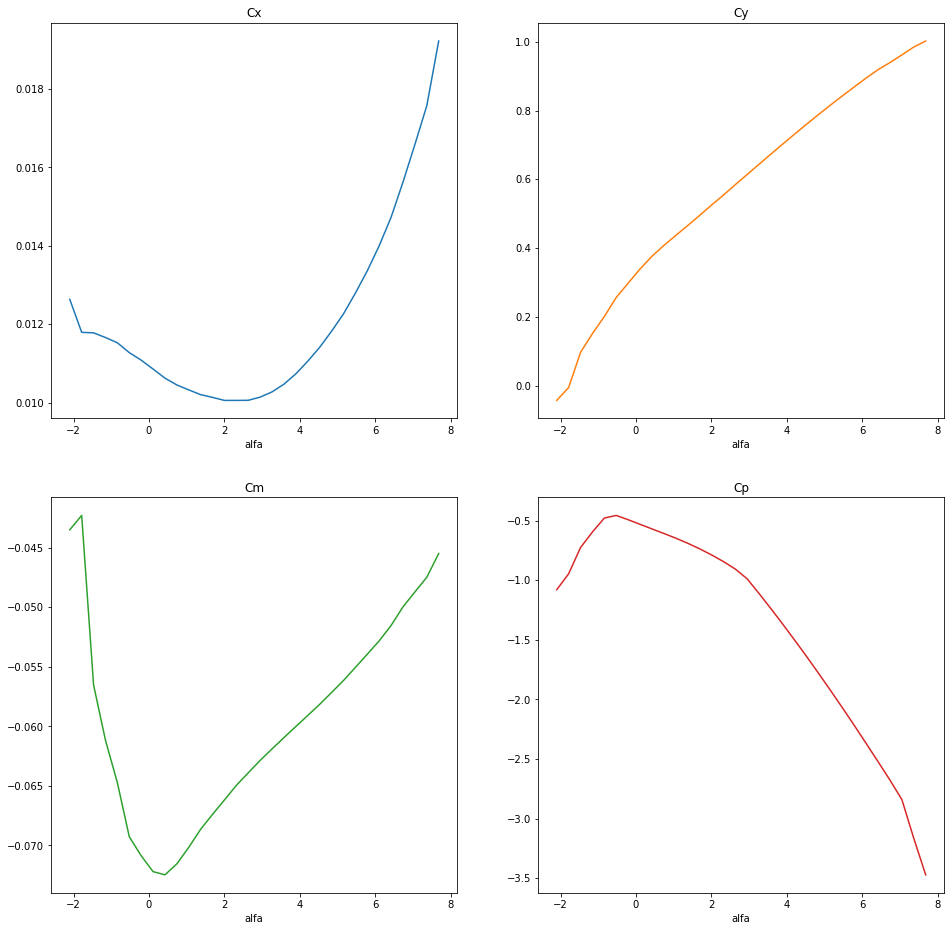

In [57]:
print("Foil %s, Re=%i, S=%2.6s, d=%2.6s" % (fname, desired_Re, S, d))
fig, axs = plt.subplots(2, 2, figsize=(16,16))
fig.dpi
axs[0, 0].plot(alfas, Cx)
axs[0, 0].set_title('Cx')
axs[0, 1].plot(alfas, Cy, 'tab:orange')
axs[0, 1].set_title('Cy')
axs[1, 0].plot(alfas, Cm, 'tab:green')
axs[1, 0].set_title('Cm')
axs[1, 1].plot(alfas, Cp, 'tab:red')
axs[1, 1].set_title('Cp')

for ax in axs.flat:
    ax.set(xlabel='alfa', ylabel='')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer();

In [64]:
y = np.round(model.predict(X[None,:]))[0, :, :, 0]
y.shape

(512, 512)

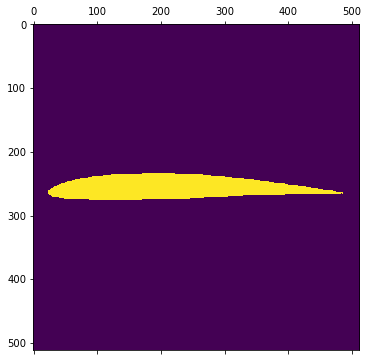

In [68]:
plt.figure(figsize=(16,6))
plt.matshow(y,0)

In [73]:
# ищем координаты

# сначала определим координаты начала и конца оси профиля

for x_nose in range(y.shape[1]):
    res = find_first_and_last_1_position(y[:, x_nose])
    if res!=-1:
        y_nose_top, y_nose_bot = res
        break
        
for x_tail in range(y.shape[1]-1,0,-1):
    res = find_first_and_last_1_position(y[:, x_tail])
    if res!=-1:
        y_tail_top, y_tail_bot = res
        break

if y_nose_top!=y_nose_bot: # ставим точку в середине носика, пригодится для красивой аппроксимации
    y_nose = int(np.average((y_nose_top, y_nose_bot)))
    y[y_nose,x_nose-1]=1
    x_nose-=1

if y_tail_top!=y_tail_bot: # а на хвостике не ставим и вообще хз чё делаем - к Димке
    pass
#     y_tail = int(np.average((y_tail_top, y_tail_bot)))
# else:
#     y_tail = y_tail_top
    
print(x_nose, y_nose, x_tail)

y=y[:, x_nose:x_tail+1]

foil_x_top = (np.arange(y.shape[1])).tolist(); foil_x_top.reverse()
foil_x_bot = foil_x_top.copy() #foil_x[:-1]; x2.reverse() ; foil_x.extend(x2)
foil_y_top=[]
foil_y_bot=[]
for x in foil_x_top:
    if find_first_and_last_1_position(y[:, x])==-1: raise Exception
    y_t, y_b = find_first_and_last_1_position(y[:, x])
    foil_y_top.append(y_nose - y_t)
    foil_y_bot.append(y_nose - y_b)
foil_x_bot = foil_x_bot[:-1]
foil_x_bot.reverse()
foil_y_bot = foil_y_bot[:-1]
foil_y_bot.reverse()
foil_x_top.extend(foil_x_bot)
foil_y_top.extend(foil_y_bot)
foil_x = np.array(foil_x_top)/(y.shape[1]-1)
foil_y = np.array(foil_y_top)/(y.shape[1]-1)
foil_x.shape, foil_y.shape

22 265 484


((925,), (925,))

In [74]:
f_x, f_y = interpolate_airfoil(foil_x, foil_y, 256)